In [1]:
import numpy as np
from scipy.stats import binom, gaussian_kde
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Análisis


In [10]:
figure_dir = '/content/drive/MyDrive/MEFE/Parcial Computacional/figuras'
os.makedirs(figure_dir, exist_ok=True)


np.random.seed(42)  # Reproducibilidad
n_words = 10        # Palabras por prueba
n_tests = 600       # Pruebas por grupo
alpha = 0.05        # Nivel de significancia
f_values = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.06])
n_sim = 5000        # Simulaciones para distribuciones
power_sim = 1000    # Simulaciones para potencia


plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "serif"


In [11]:
control_data = binom.rvs(n=n_words, p=0.6, size=n_tests)
p0 = np.sum(control_data) / (n_tests * n_words)
print(f"Estimación de p0: Teórico = {0.6}, Estimado = {p0:.4f}\n")


Estimación de p0: Teórico = 0.6, Estimado = 0.6007



In [52]:
confidence_level = 0.95  # Nivel de confianza


np.random.seed(42)
control_data = binom.rvs(n=n_words, p=0.6, size=n_tests)


total_words = n_tests * n_words
total_success = np.sum(control_data)
p0_hat = total_success / total_words


se_p0 = np.sqrt(p0_hat * (1 - p0_hat) / total_words)





print(f"Estimación: {p0_hat}")
print(f"Error estándar: ±{se_p0}")


=== Estimación de p0 ===
Valor teórico: 0.6
Estimación puntual: 0.6006666666666667
Error estándar: ±0.006322792397643917


In [12]:

def log_likelihood(data, p):
    k = np.sum(data)
    n = len(data) * n_words
    eps = 1e-10
    p_clipped = np.clip(p, eps, 1-eps)
    return k * np.log(p_clipped) + (n - k) * np.log(1 - p_clipped)

def delta_log_likelihood(data, f, p0=p0, n_words=n_words):
    return log_likelihood(data, p0 + f) - log_likelihood(data, p0)

def simulate_null_distribution(f, n_sim=n_sim):
    null_stats = np.zeros(n_sim)
    for i in range(n_sim):
        data = binom.rvs(n=n_words, p=p0, size=n_tests)
        null_stats[i] = delta_log_likelihood(data, f)
    return null_stats

def calculate_power(f, critical_value, n_sim=power_sim):
    rejections = 0
    for _ in range(n_sim):
        data = binom.rvs(n=n_words, p=p0 + f, size=n_tests)
        stat = delta_log_likelihood(data, f)
        if stat > critical_value:
            rejections += 1
    return rejections / n_sim

def run_hypothesis_test(f_test, n_tests=n_tests, alpha=alpha, n_sim=n_sim):
    test_data = binom.rvs(n=n_words, p=p0 + f_test, size=n_tests)
    null_dist = simulate_null_distribution(f_test, n_sim)
    critical_value = np.percentile(null_dist, 100*(1-alpha))


    delta_obs = delta_log_likelihood(test_data, f_test)
    p_value = np.mean(null_dist >= delta_obs)

    return {
        'f_test': f_test,
        'critical_value': critical_value,
        'delta_obs': delta_obs,
        'p_value': p_value,
        'null_dist': null_dist,
        'test_data': test_data
    }

def format_p_value(p):
    return f"{p:.2e}" if p < 1e-4 else f"{p:.4f}"


/tmp/ipython-input-22-1943296292.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


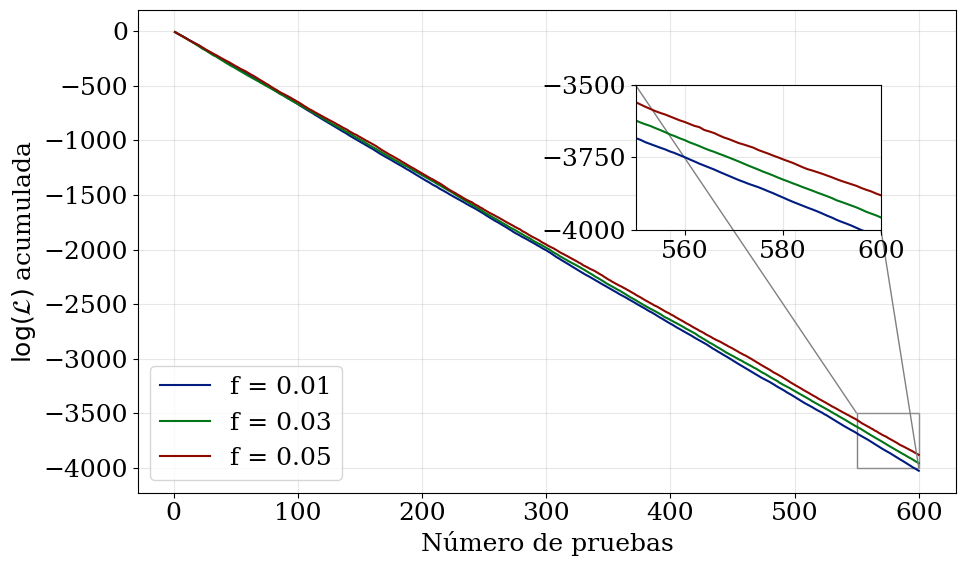

In [22]:
def plot_acumulada_logL_absoluta():
    fig, ax = plt.subplots()

    f_vals = [0.01, 0.03, 0.05]

    curvas = []
    for i, f in enumerate(f_vals):
        p_exp = p0 + f
        data = binom.rvs(n=n_words, p=p_exp, size=n_tests)
        ll_acum = np.cumsum([log_likelihood([x], p_exp) for x in data])
        curva, = ax.plot(range(1, n_tests + 1), ll_acum, label=f'f = {f_vals[i]}')
        curvas.append(ll_acum)

    ax.set_xlabel("Número de pruebas")
    ax.set_ylabel(r"$\log(\mathcal{L})$ acumulada")
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)

    axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=3)

    for i, f in enumerate(f_vals):
        axins.plot(range(1, n_tests + 1), curvas[i])

    axins.set_xlim(550, 600)
    axins.set_ylim(-4000, -3500)

    axins.tick_params(axis='both')
    axins.grid(True, alpha=0.3)

    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'logL_acumulada_H1_zoom.png'), dpi=300)
    plt.show()

plot_acumulada_logL_absoluta()


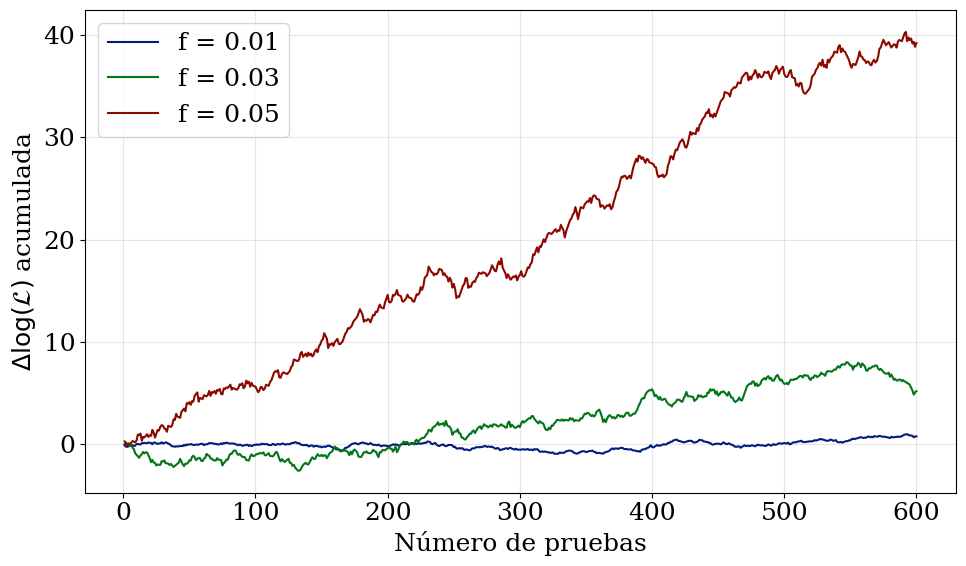

In [25]:
def plot_cumulative_likelihood():
    for f in [0.01, 0.03, 0.05]:
        p_exp = p0 + f
        exp_data = binom.rvs(n=n_words, p=p_exp, size=n_tests)
        delta_ll = np.cumsum([delta_log_likelihood([x], f) for x in exp_data])
        plt.plot(range(1, n_tests+1), delta_ll, label=f'f = {f}')

    plt.xlabel('Número de pruebas')
    plt.ylabel(r'$\Delta\log(\mathcal{L})$ acumulada')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'acumulacion_evidencia.png'), dpi=300)
    plt.show()

plot_cumulative_likelihood()

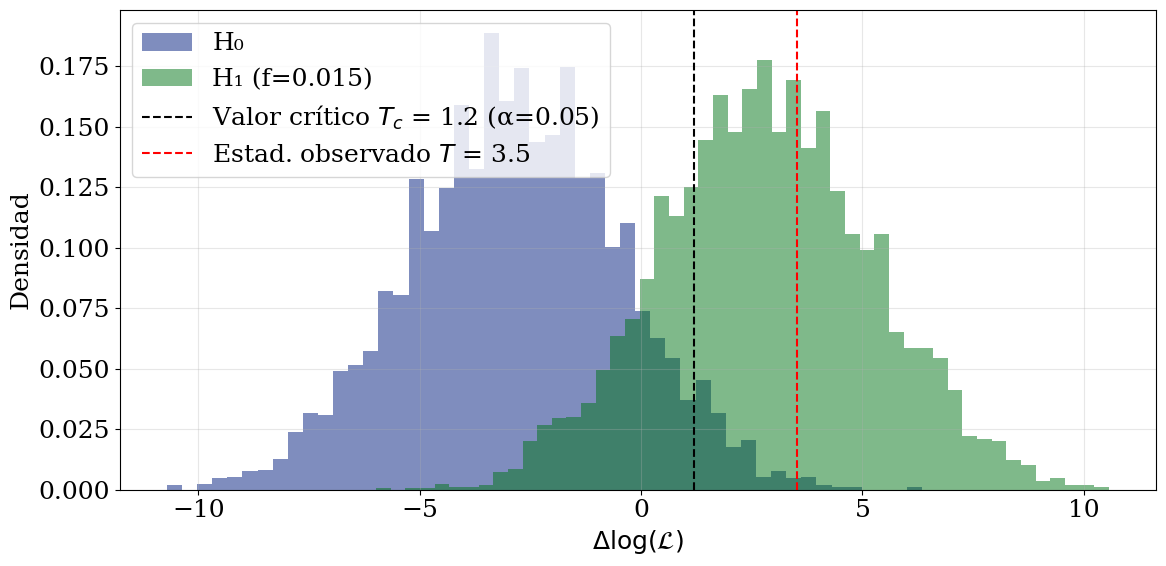


=== Resultados del Test ===
Valor crítico: 1.1
Estadístico observado: 3.5
p-valor: 0.0030
Conclusión: Rechazamos H0


In [58]:
def plot_h0_vs_h1_distribution(f_ejemplo=0.015):
    null_dist = np.array([
        delta_log_likelihood(binom.rvs(n=n_words, p=p0, size=n_tests), f_ejemplo)
        for _ in range(n_sim)
    ])
    critical_value = np.percentile(null_dist, 100*(1-alpha))

    h1_dist = np.array([
        delta_log_likelihood(binom.rvs(n=n_words, p=p0 + f_ejemplo, size=n_tests), f_ejemplo)
        for _ in range(n_sim)
    ])


    test = run_hypothesis_test(f_ejemplo)

    plt.figure(figsize=(12, 6))
    plt.hist(null_dist, bins=50, density=True, alpha=0.5, label='H₀')
    plt.hist(h1_dist, bins=50, density=True, alpha=0.5, label=f'H₁ (f={f_ejemplo})')
    plt.axvline(critical_value, color='black', linestyle='--',
                label=f'Valor crítico $T_c$ = {critical_value:.1f} (α={alpha})')
    plt.axvline(test['delta_obs'], color='red', linestyle='--',
                label=f'Estad. observado $T$ = {test["delta_obs"]:.1f}')

    plt.xlabel(r'$\Delta\log(\mathcal{L})$')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'distribuciones_H0_H1.png'), dpi=300)
    plt.show()

    print(f"Valor crítico: {test['critical_value']:.1f}")
    print(f"Estadístico observado: {test['delta_obs']:.1f}")
    print(f"p-valor: {format_p_value(test['p_value'])}")
    print("Conclusión:", "Rechazamos H0" if test['p_value'] < alpha else "No rechazamos H0")

plot_h0_vs_h1_distribution()



Calculando curva de potencia: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


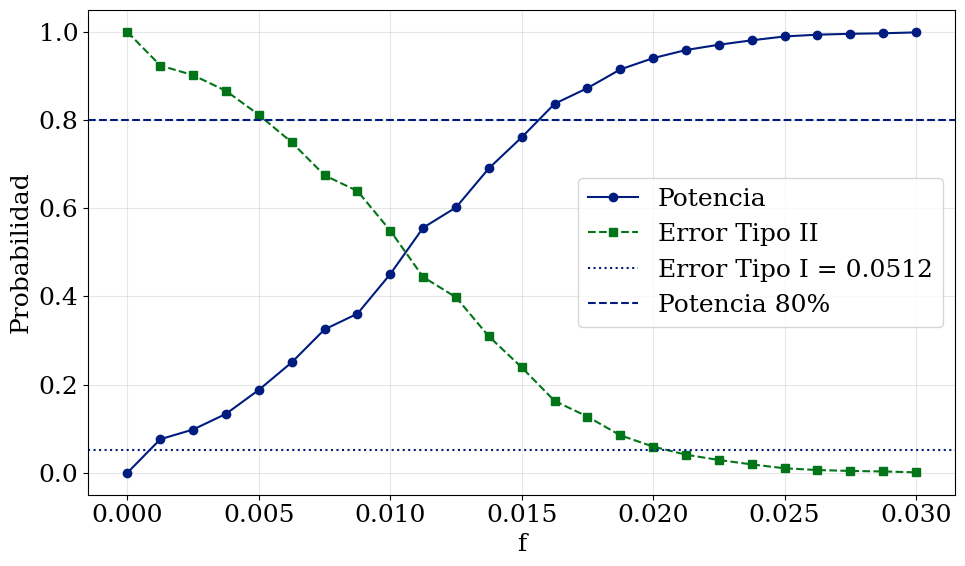

In [62]:
def plot_enhanced_power_curve():
    f_range = np.linspace(0, 0.03, 25)
    power_values = []
    type_II_errors = []

    for f in tqdm(f_range, desc="Calculando curva de potencia"):
        null_dist = simulate_null_distribution(f, n_sim//2)
        crit_val = np.percentile(null_dist, 100*(1-alpha))
        power = np.mean([delta_log_likelihood(binom.rvs(n=n_words, p=p0 + f, size=n_tests), f) > crit_val
                        for _ in range(n_sim//2)])
        power_values.append(power)
        type_I_error = np.mean(null_dist >= crit_val)
        type_II_errors.append(1 - power)

    fig, ax = plt.subplots()

    ax.plot(f_range, power_values, 'o-', label='Potencia')
    ax.plot(f_range, type_II_errors, 's--', label='Error Tipo II')
    ax.axhline(type_I_error, linestyle=':', label=f'Error Tipo I = {type_I_error}')
    ax.axhline(0.8, linestyle='--', label='Potencia 80%')

    ax.set_xlabel('f')
    ax.set_ylabel('Probabilidad')
    ax.legend(loc='center right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'curva_potencia_mejorada.png'), dpi=300)
    plt.show()

plot_enhanced_power_curve()

Calculando sensibilidad: 100%|██████████| 30/30 [02:49<00:00,  5.66s/it]


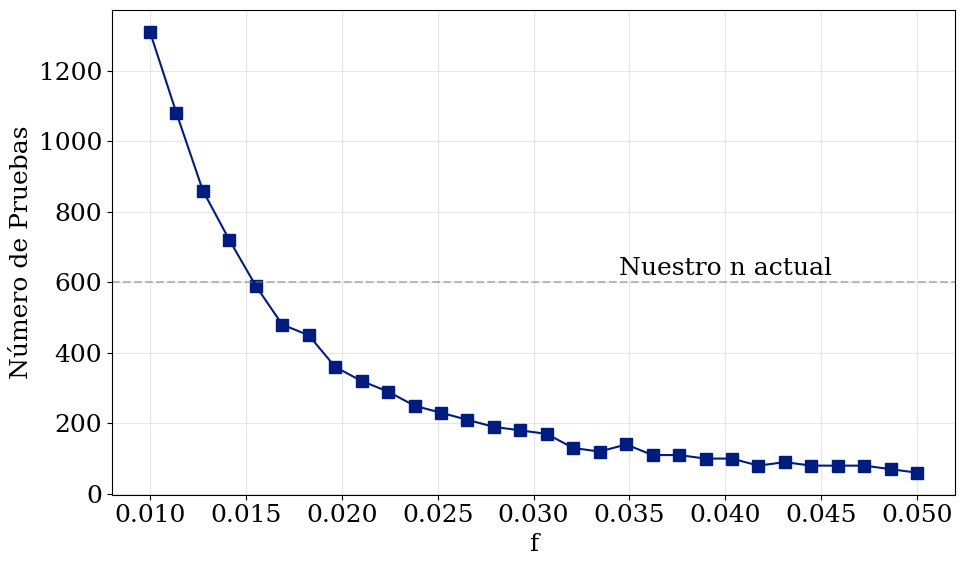

In [43]:
def plot_effect_size_sensitivity():

    f_range = np.linspace(0.01, 0.05, 30)
    required_n = []

    for f in tqdm(f_range, desc="Calculando sensibilidad"):
        for n in range(50, 2001, 10):

            null_dist = np.zeros(1000)
            for i in range(1000):
                data = binom.rvs(n=n_words, p=p0, size=n)
                null_dist[i] = delta_log_likelihood(data, f)

            crit_val = np.percentile(null_dist, 95)


            power = 0
            for _ in range(500):
                data = binom.rvs(n=n_words, p=p0 + f, size=n)
                stat = delta_log_likelihood(data, f)
                if stat > crit_val:
                    power += 1
            power /= 500

            if power >= 0.8:
                required_n.append(n)
                break
        else:
            required_n.append(2000)


    plt.figure()
    plt.plot(f_range, required_n, 's-', markersize=8)


    plt.axhline(600, color='gray', linestyle='--', alpha=0.5)
    plt.text(0.04, 620, 'Nuestro n actual', ha='center')


    plt.xlabel('f')
    plt.ylabel('Número de Pruebas')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'sensibilidad_tamano_efecto.png'), dpi=300)
    plt.show()

    plt.close()

plot_effect_size_sensitivity()


Tamaño de efecto mínimo detectable con 80% de potencia: 0.0157


Analizando sensibilidad: 100%|██████████| 46/46 [06:31<00:00,  8.50s/it]


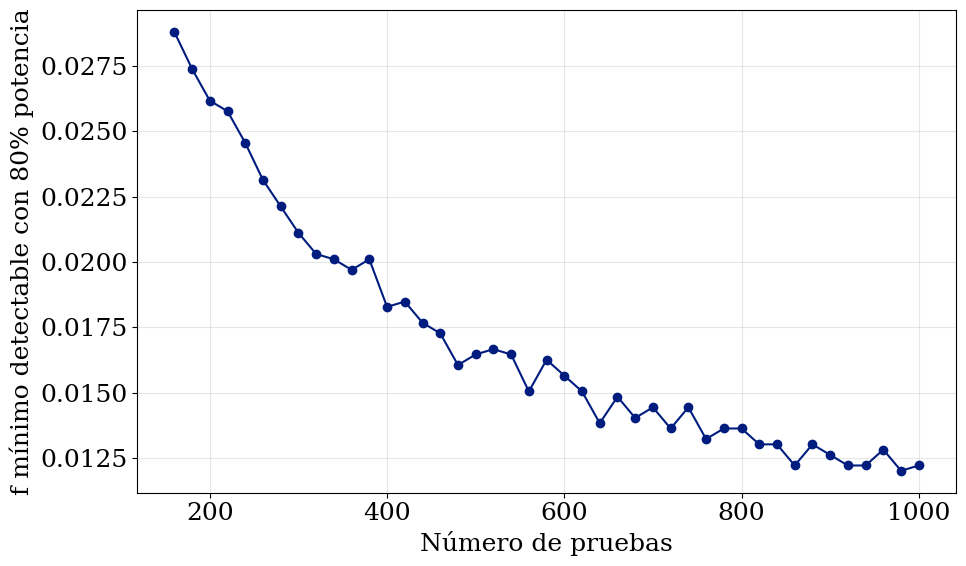

In [18]:
def find_min_detectable_effect(power_threshold=0.8):

    for f in np.linspace(0.01, 0.03, 100):
        null_dist = simulate_null_distribution(f, 2000)
        crit_val = np.percentile(null_dist, 100*(1-alpha))
        power = calculate_power(f, crit_val, 1000)
        if power >= power_threshold:
            return f
    return None

min_effect = find_min_detectable_effect()
print(f"\nTamaño de efecto mínimo detectable con 80% de potencia: {min_effect:.4f}")


sample_sizes = np.arange(100, 1001, 20)
effect_sizes = []

for n in tqdm(sample_sizes, desc="Analizando sensibilidad"):
    for f in np.linspace(0.01, 0.03, 100):

        null_dist = np.zeros(1000)
        for i in range(1000):
            data = binom.rvs(n=n_words, p=p0, size=n)
            null_dist[i] = delta_log_likelihood(data, f)

        crit_val = np.percentile(null_dist, 100*(1-alpha))


        power = 0
        for _ in range(500):
            data = binom.rvs(n=n_words, p=p0 + f, size=n)
            stat = delta_log_likelihood(data, f)
            if stat > crit_val:
                power += 1
        power /= 500

        if power >= 0.8:
            effect_sizes.append(f)
            break
    else:
        effect_sizes.append(np.nan)

plt.figure()
plt.plot(sample_sizes, effect_sizes, 'o-')
plt.xlabel('Número de pruebas')
plt.ylabel('f mínimo detectable con 80% potencia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'sensibilidad__minimo_detectable.png'), dpi=300)
plt.show()

Generando gráficos: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


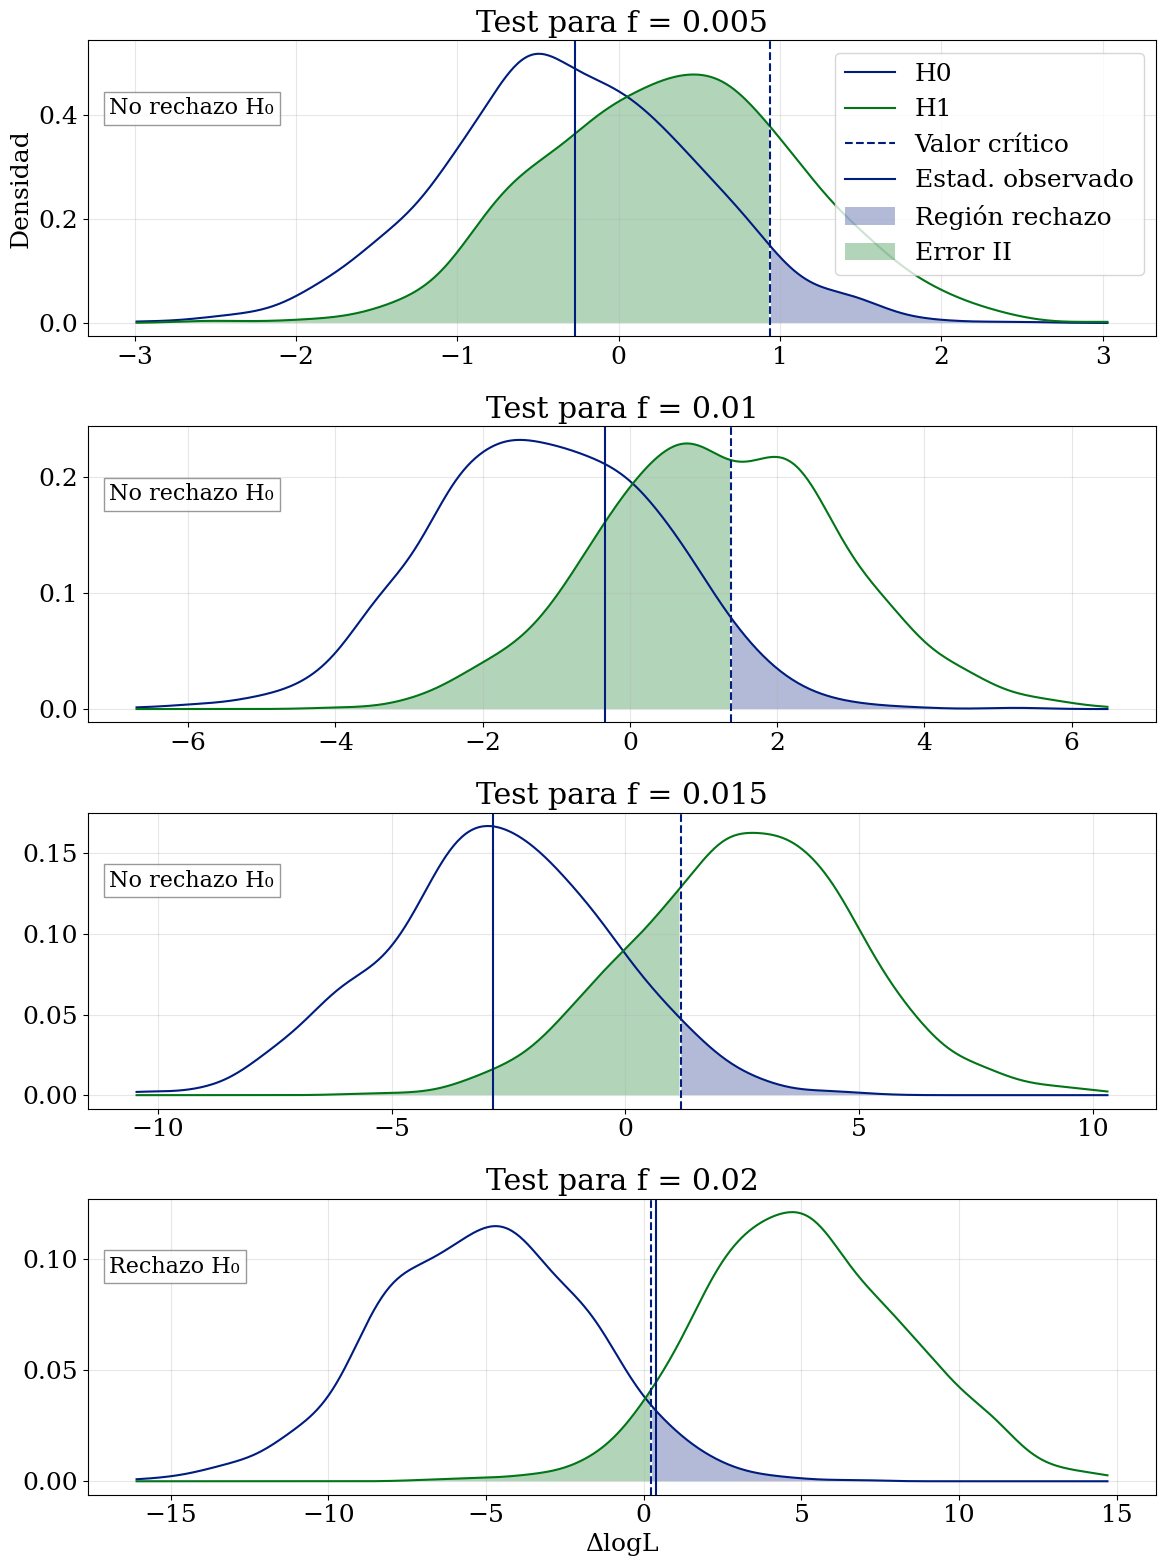

In [19]:
def plot_enhanced_hypothesis_test(f_values, n_sim=1000):

    n_plots = len(f_values)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots))

    if n_plots == 1:
        axes = [axes]

    for idx, f in enumerate(tqdm(f_values, desc="Generando gráficos")):
        ax = axes[idx]


        null_dist = simulate_null_distribution(f, n_sim)
        h1_dist = np.array([
            delta_log_likelihood(binom.rvs(n=n_words, p=p0 + f, size=n_tests), f)
            for _ in range(n_sim)
        ])

        crit_val = np.percentile(null_dist, 100 * (1 - alpha))
        obs_stat = delta_log_likelihood(binom.rvs(n=n_words, p=p0 + f, size=n_tests), f)
        power = np.mean(h1_dist > crit_val)
        p_value = np.mean(null_dist >= obs_stat)
        conclusion = "Rechazo H₀" if p_value < alpha else "No rechazo H₀"

        x_range = np.linspace(min(null_dist.min(), h1_dist.min()),
                              max(null_dist.max(), h1_dist.max()), 500)
        kde_null = gaussian_kde(null_dist)
        kde_h1 = gaussian_kde(h1_dist)

        ax.plot(x_range, kde_null(x_range), label=f'H0')
        ax.plot(x_range, kde_h1(x_range), label=f'H1')
        ax.axvline(crit_val, linestyle='--', label=f'Valor crítico')
        ax.axvline(obs_stat, label=f'Estad. observado')

        rejection_region = x_range[x_range >= crit_val]
        ax.fill_between(rejection_region, kde_null(rejection_region), alpha=0.3, label='Región rechazo')
        ax.fill_between(x_range[x_range <= crit_val], kde_h1(x_range[x_range <= crit_val]), alpha=0.3, label=f'Error II')

        ax.set_title(f'Test para f = {f}')

        if idx != n_plots - 1:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('ΔlogL')

        if idx == 0:
            ax.set_ylabel('Densidad')
            ax.legend(loc='upper right')
        else:
            ax.set_ylabel('')
            ax.legend().set_visible(False)

        ax.grid(alpha=0.3)
        ax.text(0.02, 0.75,
                f'{conclusion}',
                transform=ax.transAxes,
                fontsize=16,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'comparacion_hipotesis.png'), dpi=300)
    plt.show()

plot_enhanced_hypothesis_test([0.005, 0.01, 0.015, 0.02])